In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/My Drive/Colab Notebooks
# RMS prop run again to get less std.

In [0]:
# Importing Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse, copy

from model import *
from utils import *
from measures import *

In [0]:
validation_losses = []
seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 5
    lrs = [3e-2, 3e-3, 3e-4, 3e-5, 3e-6]  
    gamma = 0.7
    momentum = 0.9

    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)
    
    # Grid Search over different learning rates - over validation dataset
    val_losses = []
    for lr in lrs:
        print ("lr:", lr)
        model_copy = copy.deepcopy(model)
        optimizer = optim.RMSprop(model_copy.parameters(), lr=lr, momentum=momentum)
        scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

        for epoch in range(1, epochs + 1):
            train_loss = train(model_copy, device, train_loader, optimizer, epoch, batch_size)
            val_loss = test_2(model_copy, device, val_loader, batch_size, val_size)
            # test_loss = test(model_copy, device, test_loader, batch_size)  # one can see on test_loss as well.....
            scheduler.step()
        val_losses.append(val_loss)
    # print ("Validation Losses::\n", val_losses)  
    validation_losses.append(val_losses)  

seed::: 12345
54000 6000 10000
lr: 0.03

Test set: Average loss: 2.3014, Accuracy: 638/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)


Test set: Average loss: 2.3018, Accuracy: 637/6000 (11%)

lr: 0.003

Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)

lr: 0.0003

Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)


Test set: Average loss: 2.3026, Accuracy: 635/6000 (11%)

lr: 3e-05

Test set: Average loss: 0.8118, Accuracy: 4

In [0]:
print (validation_losses)
validation_losses = np.mean(np.array(validation_losses), 0)
print (validation_losses)

[[2.3018193955117083, 2.3025848789417998, 2.3025848789417998, 0.7720230332714446, 0.16597933678867968], [2.3025848789417998, 2.582330860990159, 2.3025848789417998, 0.05322188887982927, 0.3925278814549142], [2.3025848789417998, 2.3025848789417998, 2.3025848789417998, 0.5010865295821048, 0.1559937876906801]]
[2.30232972 2.39583354 2.30258488 0.44211048 0.238167  ]


'best lr = 3e-6 in case of RMSprop'

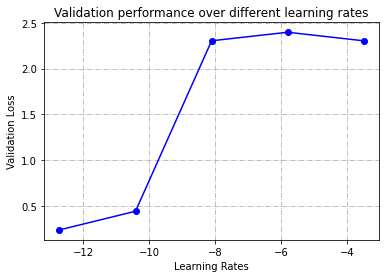

In [0]:
# Learning Rates - ['3e-2', '3e-3', '3e-4', '3e-5', '3e-6'] plotted on log scale
lr_rates = np.log(np.array(lrs))
fig = plt.figure()
plt.plot(lr_rates, validation_losses, color='blue', marker='o') 
plt.xlabel('Learning Rates')
plt.ylabel('Validation Loss')
plt.title("Validation performance over different learning rates")
plt.grid(True, linestyle='-.')
fig.show()   
# plt.legend(['3e-2', '3e-3', '3e-4', '3e-5', '3e-6'], loc='upper right')
"""best lr = 3e-6 in case of RMSprop"""

In [0]:
avg_train_losses, avg_test_losses, avg_difference_test_train = [], [], []
avg_weight_norms_list, avg_sharpness_list, avg_std_list, avg_mean_list = [], [], [], []

seeds = [12345, 1234, 123]
for seed in seeds:
    print ("seed:::", seed)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model Hyperparamters
    batch_size = 64
    epochs = 14
    lr = 3e-6 # good one - lowest validation loss among others
    gamma = 0.7
    momentum = 0.9

    use_cuda = torch.cuda.is_available()
    train_loader, val_loader, test_loader, train_size, val_size = dataloaders(batch_size, use_cuda, seed)
    print (train_size, val_size, len(test_loader.dataset))

    model = Net().to(device)

    train_losses, test_losses = [], []
    sigmas = [0.001,0.003,0.006,0.009,0.03,0.06,0.09]    
    # sigmas = [0.09]
    delta = 1e-2
    mean = 0.0
    weight_norms_list = []
    sharpness_list = []

    optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, batch_size)
        train_losses.append(train_loss)
        test_loss = test(model, device, test_loader, batch_size)
        test_losses.append(test_loss)
        scheduler.step()
    
    avg_train_losses.append(train_losses) 
    avg_test_losses.append(test_losses)
    # show_losses(train_losses, test_losses)  # show at the end

    # print train and test losses and their difference
    difference_test_train = np.array(test_losses)  - np.array(train_losses)
    # print ("diff_test_train::\n", difference_test_train)
    avg_difference_test_train.append(difference_test_train)

    print ("running for sigmas")
    """run for each sigma"""
    std_list = []
    mean_list = []

    for sigma in sigmas:
        weight_l2_norm = cal_l2_norm(model)
        weight_bound = compute_bound(model, train_size, sigma, weight_l2_norm, delta)  
        weight_norms_list.append(weight_bound)
        # print ("norm bound:::", weight_bound)

        #to calculate sharpness, perturb the same model 10 times, then get expected value
        num_times = 20
        p_train_losses = []
        for iterate in range(num_times):
            p_model = copy.deepcopy(model)
            p_model = weight_pertubation(p_model, mean, sigma, device)
            p_train_loss = test_2(p_model, device, train_loader, batch_size, train_size)
            p_train_losses.append(p_train_loss)
        exp_p_error = sum(p_train_losses) / len(p_train_losses)
        std_list.append(np.std(np.array(p_train_losses)))
        mean_list.append(np.mean(np.array(p_train_losses)))

        sharpness = exp_p_error - train_loss
        # print ("sharpness:::", sharpness)
        sharpness_list.append(sharpness)
    
    avg_weight_norms_list.append(weight_norms_list)
    avg_sharpness_list.append(sharpness_list)
    avg_std_list.append(std_list)
    avg_mean_list.append(mean_list)

seed::: 12345
54000 6000 10000

Test set: Average loss: 0.6932, Accuracy: 7525/10000 (75%)


Test set: Average loss: 0.6466, Accuracy: 7638/10000 (76%)


Test set: Average loss: 0.6223, Accuracy: 7674/10000 (77%)


Test set: Average loss: 0.6134, Accuracy: 7706/10000 (77%)


Test set: Average loss: 0.6045, Accuracy: 7718/10000 (77%)


Test set: Average loss: 0.6021, Accuracy: 7724/10000 (77%)


Test set: Average loss: 0.5955, Accuracy: 7726/10000 (77%)


Test set: Average loss: 0.5953, Accuracy: 7732/10000 (77%)


Test set: Average loss: 0.5929, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5930, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5932, Accuracy: 7733/10000 (77%)


Test set: Average loss: 0.5899, Accuracy: 7735/10000 (77%)


Test set: Average loss: 0.5927, Accuracy: 7734/10000 (77%)


Test set: Average loss: 0.5917, Accuracy: 7735/10000 (77%)

running for sigmas

Test set: Average loss: 0.5809, Accuracy: 42037/54000 (78%)


Test set: Average loss: 0.5810, A

In [0]:
print (avg_difference_test_train)
print (avg_weight_norms_list)
print (avg_sharpness_list)
print (avg_std_list)

[array([-0.17388522, -0.02487513, -0.01319008, -0.00228534,  0.00085315,
        0.00611789,  0.00452442,  0.00781684,  0.00756124,  0.0093749 ,
        0.01054103,  0.00808784,  0.01140532,  0.01061047]), array([-0.18735237, -0.0239507 , -0.01288106, -0.00391355,  0.00067194,
        0.00485264,  0.00617421,  0.00724142,  0.00839163,  0.00919296,
        0.00847412,  0.00886677,  0.00921453,  0.00978392]), array([-0.18668926, -0.02832007, -0.01401038, -0.00638161, -0.00064132,
        0.00057142,  0.00343792,  0.0038692 ,  0.00514519,  0.00604023,
        0.00603515,  0.00707423,  0.00697966,  0.0066931 ])]
[[332.5523681640625, 110.85081481933594, 55.425437927246094, 36.9503288269043, 11.085295677185059, 5.542972564697266, 3.6956756114959717], [332.2323303222656, 110.74412536621094, 55.372093200683594, 36.914764404296875, 11.074626922607422, 5.5376386642456055, 3.69212007522583], [332.18798828125, 110.72933959960938, 55.36470031738281, 36.90983963012695, 11.073148727416992, 5.53689956

In [0]:
# Average over 3 random seeds
avg_train_losses = np.mean(np.array(avg_train_losses), 0)
avg_test_losses = np.mean(np.array(avg_test_losses), 0)
avg_difference_test_train = np.mean(np.array(avg_difference_test_train), 0)

avg_weight_norms_list = np.mean(np.array(avg_weight_norms_list), 0)
avg_sharpness_list = np.mean(np.array(avg_sharpness_list), 0)
avg_std_list = np.mean(np.array(avg_std_list), 0)
avg_mean_list = np.mean(np.array(avg_mean_list), 0)


# print ("avg_train_losses:::\n", avg_train_losses)
# print ("avg_test_losses:::\n", avg_test_losses)
print ("average difference list::\n", avg_difference_test_train)
print ("avg_weight_norms_list::\n", avg_weight_norms_list)
print ("avg_sharpness_list::\n", avg_sharpness_list)
print ("avg_std_list::\n", avg_std_list)
print ("avg_mean_list::\n", avg_mean_list)


average difference list::
 [-0.18264228 -0.0257153  -0.01336051 -0.0041935   0.00029459  0.00384732
  0.00471218  0.00630916  0.00703269  0.0082027   0.0083501   0.00800961
  0.00919984  0.00902916]
avg_weight_norms_list::
 [332.32422892 110.77475993  55.38741048  36.92497762  11.07769044
   5.53917027   3.69314106]
avg_sharpness_list::
 [-9.85532483e-05  1.51516006e-03  6.66349150e-03  1.63156179e-02
  4.50531725e-01  4.95540615e+00  1.59675063e+01]
avg_std_list::
 [5.42081049e-05 2.54239183e-04 1.27949598e-03 2.98293809e-03
 1.52601387e-01 1.86666981e+00 5.18276734e+00]
avg_mean_list::
 [ 0.28015413  0.28176785  0.28691618  0.29656831  0.73078441  5.23565883
 16.24775898]


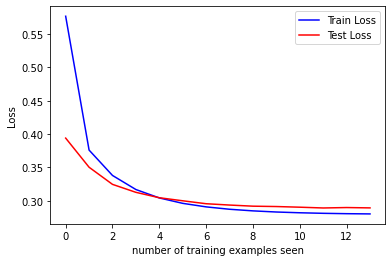

In [0]:
show_losses(avg_train_losses, avg_test_losses)

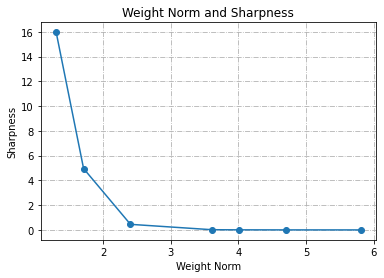

In [0]:
plt.plot(np.log(avg_weight_norms_list), avg_sharpness_list, marker='o')
plt.grid(True, linestyle='-.')
plt.title("Weight Norm and Sharpness")
plt.xlabel("Weight Norm")
plt.ylabel("Sharpness")
plt.show()
# plt.legend() #loc='lower left'